In [2]:
import pandas as pd
import gym

from tool_functions import initialize_q_table, evaluate_agent

from Algo_Fonda.qlearning import q_learning
from Algo_Fonda.sarsa import sarsa
from Algo_Fonda.every_visit_q_mc import every_visit_mc

### Création et étude de l'environnement

Nous allons entraîner notre agent Q-Learning **à naviguer de l'état de départ (S) à l'état d'arrivée (G) en marchant uniquement sur les tuiles gelées (F) et en évitant les trous (H)**.

Nous pouvons avoir deux tailles d'environnement :

- `map_name="4x4"` : une version en grille 4x4
- `map_name="8x8"` : une version en grille 8x8


L'environnement a deux modes :

- `is_slippery=False` : L'agent se déplace toujours **dans la direction prévue** en raison de la nature non glissante du lac gelé (déterministe).
- `is_slippery=True` : L'agent **peut ne pas toujours se déplacer dans la direction voulue** en raison de la nature glissante du lac gelé (stochastique).


Si l'agent **atteint l'objectif** il reçoit une **récompense de 1**, s'il ne **l'atteint pas** (se déplace seulement) il reçoit **0** et s'il **tombe dans un trou** il reçoit également **0**.

In [3]:
# 1er cas : carte 4x4 sans glisse 
env = gym.make(
    'FrozenLake-v1',
    map_name="4x4", 
    is_slippery=False
)

state_space = env.observation_space.n
print("Il y a", state_space, "états possibles")

action_space = env.action_space.n
print("Il y a", action_space, "actions possibles")

# Pour l'évaluation des modèles
eval_env = gym.make(
    'FrozenLake-v1',
    map_name="4x4", 
    is_slippery=False
)

Il y a 16 états possibles
Il y a 4 actions possibles


Nous voyons avec `Observation Space Shape Discrete(16)` que l'observation est un entier représentant la **position actuelle de l'agent comme current_row * nrows + current_col (où la row et la col commencent toutes deux à 0)**. 

Par exemple, la position du but dans la carte 4x4 peut être calculée comme suit : 3 * 4 + 3 = 15. Le nombre d'observations possibles dépend de la taille de la carte. **Par exemple, la carte 4x4 a 16 observations possibles.**


Par exemple, voici à quoi ressemble l'état = 0 :

<img src="https://huggingface.co/datasets/huggingface-deep-rl-course/course-images/resolve/main/en/notebooks/unit2/frozenlake.png" alt="FrozenLake">

In [4]:
# Hyperparamètres partagés par tous les modèles la comparison des modèles

# Entraînement
n_training_episodes = 5000  # Nombre d'épisdoes d'entrainement
max_steps = 500             # Nombre maximla d'itérations pour un épisode
learning_rate = 0.7         # Taux d'apprentissage (poids accordé au passé pour la mise à jour de la table de Q)
gamma = 0.99

# Exploration 
max_epsilon = 0.8       
min_epsilon = 0.1            
decay_rate = 0.001          # Décroissance exponentielle pour le epsillon considéré par Q de taux decay_rate

# Pour l'affichages des résultats 
res = pd.DataFrame()
smooth = 100 # Lissage des courbes

### Performances d'un "Estimateur MC - Chaque-Passage" 

In [24]:
# Obligé de réduire max_steps pour que l'algorithme converge en temps raisonnable 
mc_table = initialize_q_table(state_space, action_space)

mc_table, mc_rewards = every_visit_mc(
    n_training_episodes=n_training_episodes,
    max_steps=max_steps,
    min_epsilon=0.005,
    max_epsilon=0.9,
    decay_rate=decay_rate,
    learning_rate=learning_rate,
    gamma=gamma,
    env=env,
    Qtable=mc_table
)

100%|██████████| 5000/5000 [00:00<00:00, 6921.04it/s]


In [25]:
mc_rewards = pd.Series(mc_rewards)
mc_rewards = mc_rewards.rolling(smooth, center=True).mean()
res['IMC-FL'] = mc_rewards

In [26]:
# Lors de l'évaluation plus d'epsillon
evaluate_agent(eval_env, max_steps=100, n_eval_episodes=100, Q=mc_table)

100%|██████████| 100/100 [00:00<00:00, 4435.32it/s]


(1.0, 0.0)

*(Convergence parfaite)*

### Performances de Sarsa

In [16]:
sarsa_table = initialize_q_table(state_space, action_space)

sarsa_table, rewards = sarsa(
    n_training_episodes=n_training_episodes,
    max_steps=max_steps,
    min_epsilon=0.005,
    max_epsilon=0.9,
    decay_rate=decay_rate,
    learning_rate=learning_rate,
    gamma=gamma,
    env=env,
    Qtable=sarsa_table
)

100%|██████████| 5000/5000 [00:01<00:00, 3182.37it/s]


In [17]:
sarsa_rewards = pd.Series(rewards)
sarsa_rewards = sarsa_rewards.rolling(smooth, center=True).mean()
res['sarsa-FL'] = sarsa_rewards

In [18]:
# Lors de l'évaluation plus d'epsillon
evaluate_agent(eval_env, max_steps=100, n_eval_episodes=100, Q=sarsa_table)

100%|██████████| 100/100 [00:00<00:00, 4167.13it/s]


(1.0, 0.0)

### Performances de Q-learning

In [19]:
qlearning_table = initialize_q_table(state_space, action_space)

qlearning_table, rewards = q_learning(
    n_training_episodes=n_training_episodes,
    max_steps=max_steps,
    min_epsilon=0.005,
    max_epsilon=0.9,
    decay_rate=decay_rate,
    learning_rate=learning_rate,
    gamma=gamma,
    env=env,
    Qtable=qlearning_table
)

100%|██████████| 5000/5000 [00:01<00:00, 4520.46it/s]


In [20]:
qlearning_rewards = pd.Series(rewards)
qlearning_rewards = qlearning_rewards.rolling(smooth, center=True).mean()
res['qlearning-FL'] = qlearning_rewards

In [21]:
# Lors de l'évaluation plus d'epsillon
evaluate_agent(eval_env, max_steps=100, n_eval_episodes=100, Q=qlearning_table)

100%|██████████| 100/100 [00:00<00:00, 3891.83it/s]


(1.0, 0.0)

### Illustrations

In [22]:
import matplotlib.pyplot as plt

<AxesSubplot: xlabel='Training_episode n°', ylabel='Reward of the episode'>

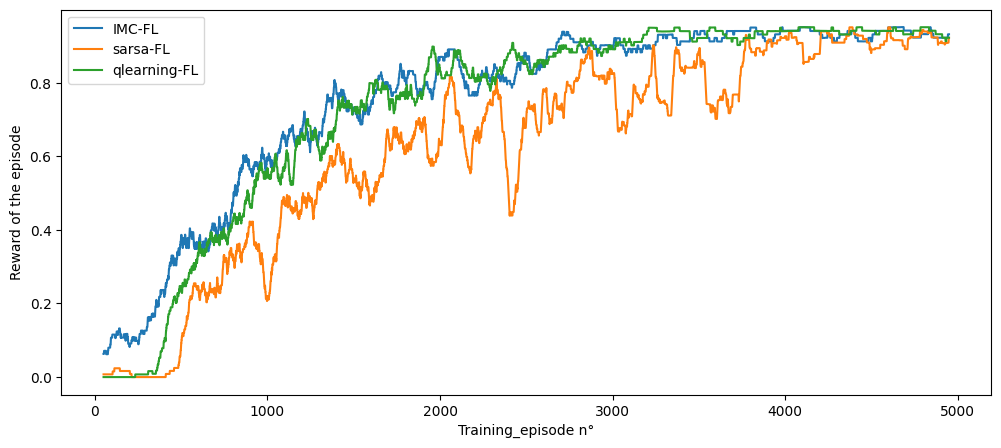

In [36]:
fig, ax = plt.subplots(figsize=(12, 5))
ax.set_ylabel('Reward of the episode')
ax.set_xlabel('Training_episode n°')
res.plot(ax=ax)

On observe bien la "sécurité" de Sarsa, qui lui coûte ici de converger moins rapidement. L'algorothme MCI est particulièrement efficace (dans sa rapidité de convergence), et une bonne optimisation pourrait faire de lui le meilleur choix dans ce cas simple.